In [4]:
from collections import defaultdict
import matplotlib.pyplot as plt
import re
from pathlib import Path
import numpy as np


In [1]:
log_files = [
    "results/FedSSDExp_10client_label_skew_weighted.log",
    "results/FedSSDExp_10client_label_skew_unweighted.log",
    "results/FedSSDExp_10client_label_skew.log",
    "results/FedSSD_10client_label_skew.log"
    #"results/FedAvg_10client_label_skew.log"
]

# log_files = [
#     "results/FD_10client_label_skew_gamma1.0_thresh0_dumb.log",
#     "results/FD_10client_label_skew_gamma1.0_dumb_selective.log",
#     "results/FedProto_10client_label_skew_gamma1.0.log",
#     "results/FedProto_10client_label_skew_gamma2.0.log"
# ]

#### Run this cell once only

In [ ]:
def parse_log(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    global_metrics = defaultdict(lambda: {'acc': [], 'f1': [], 'loss': []})
    client_metrics = defaultdict(lambda: defaultdict(lambda: {'acc': [], 'f1': [], 'loss': []}))
    has_global = False
    has_clients = False
    current_round = None
    
    for line in lines:
        round_start = re.search(r'Round\s+(\d+)/\d+', line)
        if round_start:
            current_round = int(round_start.group(1))
            continue
        
        # New format: Round X | GLOBAL | Acc: X.XXXX | F1: X.XXXX | ... | Loss: X.XXXX
        new_global_match = re.search(r'Round\s+(\d+)\s+\|\s+GLOBAL\s+\|\s+Acc:\s+([\d.]+)\s+\|\s+F1:\s+([\d.]+).*?\|\s+Loss:\s+([\d.]+)', line)
        if new_global_match:
            round_num = int(new_global_match.group(1))
            acc = float(new_global_match.group(2))
            f1 = float(new_global_match.group(3))
            loss = float(new_global_match.group(4))
            global_metrics[round_num]['acc'].append(acc)
            global_metrics[round_num]['f1'].append(f1)
            global_metrics[round_num]['loss'].append(loss)
            has_global = True
            continue
        
        # Old format compatibility
        global_match = re.search(r'Round\s+(\d+)\s+completed.*?Global\s+Test\s+Loss:\s*([\d.]+).*?Accuracy:\s*([\d.]+)%.*?F1:\s*([\d.]+)', line, re.IGNORECASE)
        if not global_match:
            global_match = re.search(r'Round\s+(\d+).*?Global.*?Acc[:\s=]+([\d.]+).*?Loss[:\s=]+([\d.]+).*?F1[:\s=]+([\d.]+)', line, re.IGNORECASE)
            if global_match:
                round_num = int(global_match.group(1))
                acc = float(global_match.group(2))
                loss = float(global_match.group(3))
                f1 = float(global_match.group(4))
                acc = acc / 100 if acc > 1 else acc
                global_metrics[round_num]['acc'].append(acc)
                global_metrics[round_num]['f1'].append(f1)
                global_metrics[round_num]['loss'].append(loss)
                has_global = True
                continue
        else:
            round_num = int(global_match.group(1))
            loss = float(global_match.group(2))
            acc = float(global_match.group(3))
            f1 = float(global_match.group(4))
            acc = acc / 100 if acc > 1 else acc
            global_metrics[round_num]['acc'].append(acc)
            global_metrics[round_num]['f1'].append(f1)
            global_metrics[round_num]['loss'].append(loss)
            has_global = True
            continue
        
        client_match = re.search(r'Client\s+(\d+)\s+.*?Acc\s*[=:]\s*([\d.]+).*?F1\s*[=:]\s*([\d.]+)', line, re.IGNORECASE)
        if client_match and current_round is not None:
            client_id = int(client_match.group(1))
            acc = float(client_match.group(2))
            f1 = float(client_match.group(3))
            acc = acc / 100 if acc > 1 else acc
            client_metrics[current_round][client_id]['acc'].append(acc)
            client_metrics[current_round][client_id]['f1'].append(f1)
            client_metrics[current_round][client_id]['loss'].append(0.0)
            has_clients = True
    
    return global_metrics, client_metrics, has_global, has_clients

def extract_algorithm_name(filepath):
    return Path(filepath).stem.replace('_', ' ')

def compute_mean_client_metrics(client_metrics):
    mean_metrics = {}
    for round_num, clients in client_metrics.items():
        acc_values = [clients[cid]['acc'][0] for cid in clients if clients[cid]['acc']]
        f1_values = [clients[cid]['f1'][0] for cid in clients if clients[cid]['f1']]
        loss_values = [clients[cid]['loss'][0] for cid in clients if clients[cid]['loss']]
        
        mean_metrics[round_num] = {
            'acc': np.mean(acc_values) if acc_values else 0,
            'f1': np.mean(f1_values) if f1_values else 0,
            'loss': np.mean(loss_values) if loss_values else 0
        }
    return mean_metrics

#### Run this everytime logfiles change

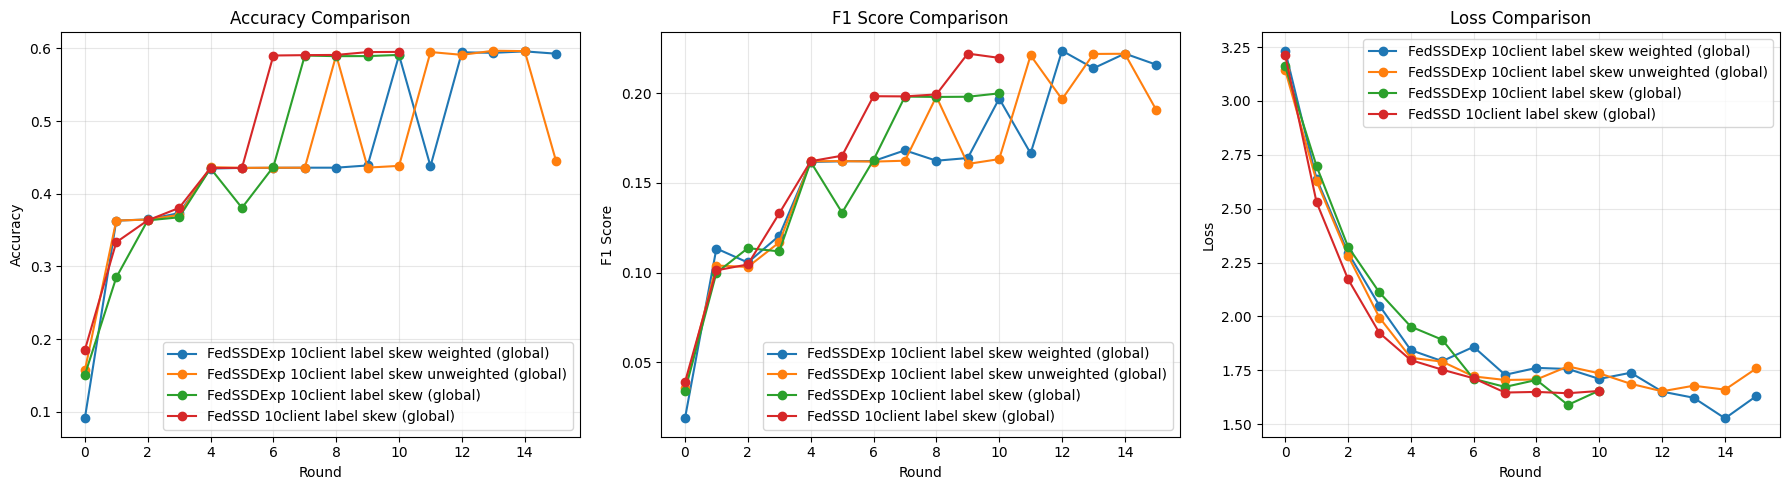

In [5]:
parsed_logs = {}
for log_file in log_files:
    global_m, client_m, has_g, has_c = parse_log(log_file)
    algo_name = extract_algorithm_name(log_file)
    parsed_logs[algo_name] = {
        'global': global_m,
        'clients': client_m,
        'has_global': has_g,
        'has_clients': has_c
    }
    
comparison_data = {}
for algo_name, data in parsed_logs.items():
    if data['has_global']:
        rounds = sorted(data['global'].keys())
        comparison_data[algo_name] = {
            'rounds': rounds,
            'acc': [data['global'][r]['acc'][0] for r in rounds],
            'f1': [data['global'][r]['f1'][0] for r in rounds],
            'loss': [data['global'][r]['loss'][0] for r in rounds],
            'type': 'global'
        }
    elif data['has_clients']:
        mean_metrics = compute_mean_client_metrics(data['clients'])
        rounds = sorted(mean_metrics.keys())
        comparison_data[algo_name] = {
            'rounds': rounds,
            'acc': [mean_metrics[r]['acc'] for r in rounds],
            'f1': [mean_metrics[r]['f1'] for r in rounds],
            'loss': [mean_metrics[r]['loss'] for r in rounds],
            'type': 'mean_clients'
        }
        
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for algo_name, data in comparison_data.items():
    label = f"{algo_name} ({'mean' if data['type'] == 'mean_clients' else 'global'})"
    axes[0].plot(data['rounds'], data['acc'], marker='o', label=label)
    axes[1].plot(data['rounds'], data['f1'], marker='o', label=label)
    axes[2].plot(data['rounds'], data['loss'], marker='o', label=label)

axes[0].set_xlabel('Round')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Round')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_xlabel('Round')
axes[2].set_ylabel('Loss')
axes[2].set_title('Loss Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [92]:
for algo_name, data in parsed_logs.items():
    if data['has_clients'] and not data['has_global']:
        client_ids = set()
        for round_clients in data['clients'].values():
            client_ids.update(round_clients.keys())
        client_ids = sorted(client_ids)
        
        rounds = sorted(data['clients'].keys())
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'{algo_name} - Per Client Performance', fontsize=14)
        
        for client_id in client_ids:
            acc_vals = []
            f1_vals = []
            loss_vals = []
            client_rounds = []
            
            for r in rounds:
                if client_id in data['clients'][r]:
                    if data['clients'][r][client_id]['acc']:
                        client_rounds.append(r)
                        acc_vals.append(data['clients'][r][client_id]['acc'][0])
                        f1_vals.append(data['clients'][r][client_id]['f1'][0])
                        loss_vals.append(data['clients'][r][client_id]['loss'][0])
            
            if client_rounds:
                axes[0].plot(client_rounds, acc_vals, marker='o', label=f'Client {client_id}', alpha=0.7)
                axes[1].plot(client_rounds, f1_vals, marker='o', label=f'Client {client_id}', alpha=0.7)
                axes[2].plot(client_rounds, loss_vals, marker='o', label=f'Client {client_id}', alpha=0.7)
        
        axes[0].set_xlabel('Round')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_title('Accuracy per Client')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].set_xlabel('Round')
        axes[1].set_ylabel('F1 Score')
        axes[1].set_title('F1 Score per Client')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        axes[2].set_xlabel('Round')
        axes[2].set_ylabel('Loss')
        axes[2].set_title('Loss per Client')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()